In [53]:
import pandas as pd
import seaborn as sns
import os
import matplotlib as plt
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_validate
from sklearn.inspection import permutation_importance
import numpy as np

In [2]:
df_gas = pd.read_csv(f'{os.path.expanduser("~")}\\IconPro GmbH\\IconPro GmbH - Dokumente\\40 Projects\\035 Talos\\Client data\\Brampton\\Gas\\Master\\agg_gas_table.csv')
df_elec = pd.read_csv(f'{os.path.expanduser("~")}\\IconPro GmbH\\IconPro GmbH - Dokumente\\40 Projects\\035 Talos\\Client data\\Brampton\\Elec\\Master\\all_elec_table.csv')

In [3]:
df_elec['time'] = pd.to_datetime(df_elec['time'])
df_elec['time'] -= pd.to_timedelta(2, unit='h')
df_elec['date'] = pd.to_datetime(pd.to_datetime(df_elec['time']).dt.date)
df_gas['date'] = pd.to_datetime(df_gas['date'])
df_gas.set_index('date', inplace=True)
df_elec = df_elec[df_elec['Measure'].str.contains('Feeder')]
df_elec_agg = df_elec.groupby(['date']).agg({'Data Point':'sum'})
df = df_gas.join(df_elec_agg[['Data Point']], how='left')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
# day of week to one hot encoding
df = pd.concat([df, pd.get_dummies(df['day_of_week'], prefix='day')], axis=1)
# create dummies for clusters
df = pd.concat([df, pd.get_dummies(df['cluster'], prefix='cluster')], axis=1)

In [5]:
df.rename(columns={'Data Point': 'elec_con'}, inplace=True)
df.replace({True: 1, False: 0}, inplace=True)
df.dropna(inplace=True)

In [6]:
fs = [
    'elec_con',
    'day',
    'production',
    'last_day_production',
    'last_day_consumption',
    'mean_temp',
    'heating_degree_hours',
    'cluster',
    'morning_temp',
    'evening_temp',
    'afternoon_temp'
]
X = df[fs]
y = df['consumption']

In [7]:
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
regr = AdaBoostRegressor(n_estimators=100)
regr.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=100)

In [8]:
# Use sequential feature selection
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(regr, n_features_to_select=8, direction='forward', cv=10)
sfs.fit(X, y)

SequentialFeatureSelector(cv=10, estimator=AdaBoostRegressor(n_estimators=100),
                          n_features_to_select=8)

In [9]:
X, y = df[X.columns[sfs.get_support()]], df['consumption']
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=12)
regr = AdaBoostRegressor()
scores = cross_validate(regr, X, y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                               'neg_mean_absolute_percentage_error'))
metrics1 = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[-1*scores['test_neg_mean_absolute_error'].mean()], 
          'rmse':[-1*scores['test_neg_root_mean_squared_error'].mean()],
          'mape':[-1*scores['test_neg_mean_absolute_percentage_error'].mean()]}, index=['adb'])
metrics1

,r2,mae,rmse,mape
adb,0.914848,13627.673722,17455.837373,0.78532


In [10]:
regr = LinearRegression()
scores = cross_validate(regr, X, y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                               'neg_mean_absolute_percentage_error'))
metrics2 = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[-1*scores['test_neg_mean_absolute_error'].mean()], 
          'rmse':[-1*scores['test_neg_root_mean_squared_error'].mean()],
          'mape':[-1*scores['test_neg_mean_absolute_percentage_error'].mean()]}, index=['lr'])
metrics2

,r2,mae,rmse,mape
lr,0.895345,14822.516741,19358.753574,0.488565


<AxesSubplot:xlabel='consumption', ylabel='consumption'>

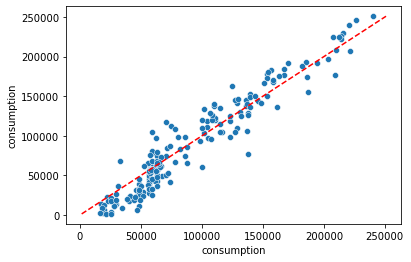

In [11]:
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
regr = AdaBoostRegressor(n_estimators=100)
regr.fit(X_train, y_train)

# Predict
prediction = regr.predict(X_test)

# Plot
sns.scatterplot(x=prediction, y=y_test)
# Plot a diagonal dotted line
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--')

In [12]:
# selected features
fs = X.columns.values

In [13]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination=0.05, random_state=42)
df['outliers'] = clf.fit_predict(np.array(X))

In [14]:
X, y = df[df['outliers']==1][fs], df[df['outliers']==1]['consumption']
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=12)
regr = AdaBoostRegressor()
scores = cross_validate(regr, X, y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                               'neg_mean_absolute_percentage_error'))
metrics3 = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[-1*scores['test_neg_mean_absolute_error'].mean()], 
          'rmse':[-1*scores['test_neg_root_mean_squared_error'].mean()],
          'mape':[-1*scores['test_neg_mean_absolute_percentage_error'].mean()]}, index=['adb_ifr'])
metrics3

,r2,mae,rmse,mape
adb_ifr,0.920321,12829.400116,16499.801582,0.774427


In [15]:
X, y = df[df['outliers']==1][fs], df[df['outliers']==1]['consumption']
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=12)
regr = LinearRegression()
scores = cross_validate(regr, X, y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                               'neg_mean_absolute_percentage_error'))
metrics4 = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[-1*scores['test_neg_mean_absolute_error'].mean()], 
          'rmse':[-1*scores['test_neg_root_mean_squared_error'].mean()],
          'mape':[-1*scores['test_neg_mean_absolute_percentage_error'].mean()]}, index=['lr_ifr'])
metrics4

,r2,mae,rmse,mape
lr_ifr,0.913267,13171.150834,17202.129377,0.544036


In [16]:
pd.concat([metrics1, metrics2, metrics3, metrics4])

,r2,mae,rmse,mape
adb,0.914848,13627.673722,17455.837373,0.785320
lr,0.895345,14822.516741,19358.753574,0.488565
adb_ifr,0.920321,12829.400116,16499.801582,0.774427
lr_ifr,0.913267,13171.150834,17202.129377,0.544036


<AxesSubplot:xlabel='consumption', ylabel='consumption'>

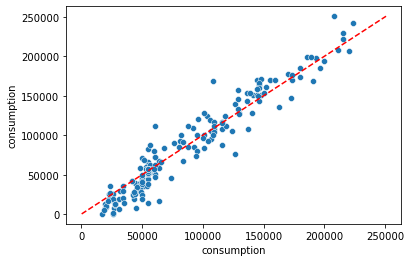

In [17]:
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
regr = AdaBoostRegressor(n_estimators=100)
regr.fit(X_train, y_train)

# Predict
prediction = regr.predict(X_test)

# Plot
sns.scatterplot(x=prediction, y=y_test)
# Plot a diagonal dotted line
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--')

In [18]:
dfgb = pd.read_csv('C:\\Users\\hahoa\\Downloads\\iconpro_talos\\features_for_autoML.csv')
fs = ['mean_temp', 'heating_degree_hours',
       'day', 'week', 'day_of_week', 'production', 'morning_temp',
       'afternoon_temp', 'evening_temp', 'mean_temp_prev_1',
       'morning_temp_prev_1', 'afternoon_temp_prev_1', 'evening_temp_prev_1',
       'heating_degree_hours_prev_1', 'mean_temp_prev_2',
       'morning_temp_prev_2', 'afternoon_temp_prev_2', 'evening_temp_prev_2',
       'heating_degree_hours_prev_2', 'mean_temp_prev_3',
       'morning_temp_prev_3', 'afternoon_temp_prev_3', 'evening_temp_prev_3',
       'heating_degree_hours_prev_3', 'last_day_production',
       'last_day_consumption', 'cluster', 'elec_con', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'cluster_0.0',
       'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0',
       'cluster_5.0', 'cluster_6.0', 'cluster_7.0']

In [19]:
X = df[fs]
y = df['consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [20]:
gbre = GradientBoostingRegressor(random_state=0)
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=12)
regr = LinearRegression()
scores = cross_validate(gbre, X, y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                               'neg_mean_absolute_percentage_error'))
metrics5 = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[-1*scores['test_neg_mean_absolute_error'].mean()], 
          'rmse':[-1*scores['test_neg_root_mean_squared_error'].mean()],
          'mape':[-1*scores['test_neg_mean_absolute_percentage_error'].mean()]}, index=['gb'])
metrics5

,r2,mae,rmse,mape
gb,0.960023,8179.388374,11940.757417,0.314125


<AxesSubplot:xlabel='consumption', ylabel='consumption'>

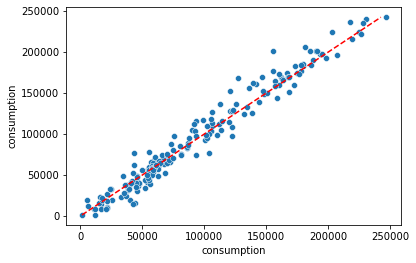

In [21]:
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
gbre = GradientBoostingRegressor()
gbre.fit(X_train, y_train)

# Predict
prediction = gbre.predict(X_test)

# Plot
sns.scatterplot(x=prediction, y=y_test)
# Plot a diagonal dotted line
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--')

In [22]:
r = permutation_importance(gbre, X_test, y_test, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    print(f"{fs[i]:<8}, {r.importances_mean[i]:.3f}, +/- {r.importances_std[i]:.3f}")

last_day_consumption, 0.442, +/- 0.042
evening_temp, 0.414, +/- 0.034
elec_con, 0.177, +/- 0.018
cluster , 0.016, +/- 0.002
production, 0.011, +/- 0.003
cluster_4.0, 0.005, +/- 0.001
day     , 0.005, +/- 0.001
last_day_production, 0.005, +/- 0.002
cluster_2.0, 0.004, +/- 0.001
cluster_3.0, 0.003, +/- 0.001
day_6   , 0.003, +/- 0.001
afternoon_temp, 0.002, +/- 0.000
cluster_1.0, 0.001, +/- 0.000
day_of_week, 0.001, +/- 0.001
heating_degree_hours_prev_1, 0.001, +/- 0.001
cluster_7.0, 0.001, +/- 0.001
heating_degree_hours, 0.001, +/- 0.000
morning_temp, 0.001, +/- 0.001
day_4   , 0.001, +/- 0.000
day_0   , 0.001, +/- 0.001
heating_degree_hours_prev_3, 0.000, +/- 0.000
day_2   , 0.000, +/- 0.000
afternoon_temp_prev_3, 0.000, +/- 0.000
week    , 0.000, +/- 0.000
day_5   , 0.000, +/- 0.001
evening_temp_prev_3, 0.000, +/- 0.000
mean_temp, 0.000, +/- 0.000
day_3   , 0.000, +/- 0.000
cluster_0.0, 0.000, +/- 0.000
cluster_5.0, 0.000, +/- 0.000
day_1   , 0.000, +/- 0.000
cluster_6.0, -0.000, +/- 

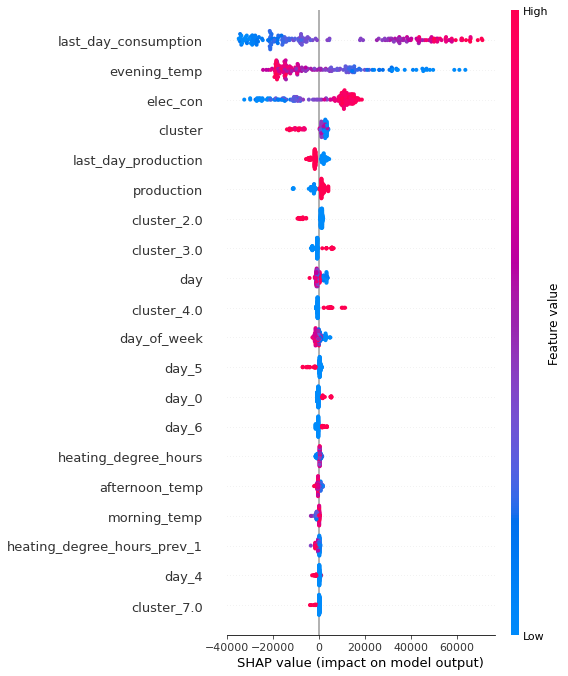

In [23]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbre)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

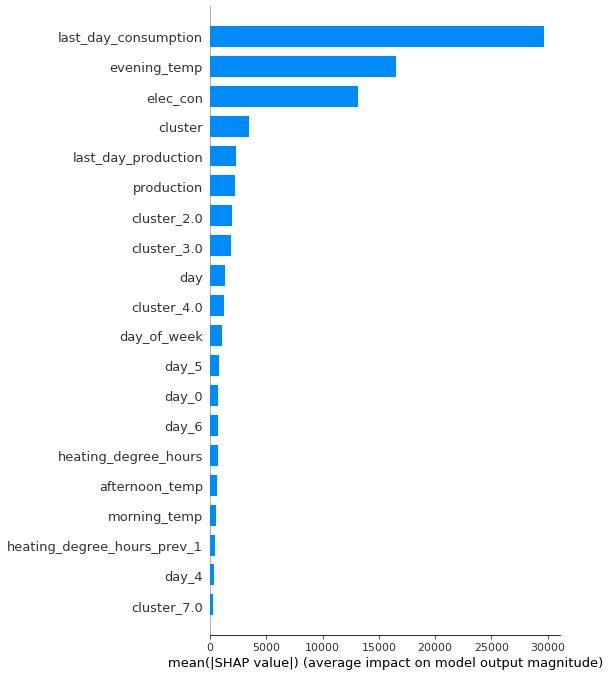

In [24]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [25]:
# https://www.datatechnotes.com/2022/03/lightgbm-regression-example-in-python.html
#!pip install lightgbm
# https://www.kaggle.com/code/lasmith/house-price-regression-with-lightgbm

# defining parameters 
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [26]:
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM

[148]	valid_0's l1: 27304	valid_0's l2: 1.15609e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's l1: 27205.2	valid_0's l2: 1.14786e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's l1: 27107	valid_0's l2: 1.13968e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's l1: 27005.3	valid_0's l2: 1.13107e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's l1: 26915.4	valid_0's l2: 1.12375e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's l1: 26821.9	valid_0's l2: 1.11628e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's l1: 26728.7	valid_0's l2: 1.10888e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's l1: 26636.4	valid_0's l2: 1.10159e+09
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's l1: 14289.2	valid_0's l2: 3.49324e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's l1: 14254.4	valid_0's l2: 3.47893e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's l1: 14219.9	valid_0's l2: 3.46475e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's l1: 14185.7	valid_0's l2: 3.45073e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	valid_0's l1: 14151.6	valid_0's l2: 3.43681e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's l1: 14112.9	valid_0's l2: 3.42067e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's l1: 14073.1	valid_0's l2: 3.40415e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	valid_0's l1: 14

[568]	valid_0's l1: 9582.97	valid_0's l2: 1.78866e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[569]	valid_0's l1: 9571.87	valid_0's l2: 1.78491e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[570]	valid_0's l1: 9562.1	valid_0's l2: 1.78191e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[571]	valid_0's l1: 9549.98	valid_0's l2: 1.77842e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[572]	valid_0's l1: 9538.44	valid_0's l2: 1.77462e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[573]	valid_0's l1: 9529.97	valid_0's l2: 1.77211e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[574]	valid_0's l1: 9519.95	valid_0's l2: 1.76898e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[575]	valid_0's l1: 9508.59	valid_0's l2: 1.76562e+08
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[780]	valid_0's l1: 8302.9	valid_0's l2: 1.36989e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[781]	valid_0's l1: 8301.05	valid_0's l2: 1.36928e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[782]	valid_0's l1: 8299.2	valid_0's l2: 1.36868e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[783]	valid_0's l1: 8296.55	valid_0's l2: 1.36744e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[784]	valid_0's l1: 8294.72	valid_0's l2: 1.36685e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[785]	valid_0's l1: 8291.85	valid_0's l2: 1.36564e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[786]	valid_0's l1: 8289.54	valid_0's l2: 1.36499e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[787]	valid_0's l1: 8287

[988]	valid_0's l1: 7845.86	valid_0's l2: 1.22035e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	valid_0's l1: 7845.31	valid_0's l2: 1.22006e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's l1: 7843.4	valid_0's l2: 1.21962e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[991]	valid_0's l1: 7843.89	valid_0's l2: 1.21975e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	valid_0's l1: 7844.38	valid_0's l2: 1.21988e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	valid_0's l1: 7843.37	valid_0's l2: 1.21975e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[994]	valid_0's l1: 7842.53	valid_0's l2: 1.21968e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[995]	valid_0's l1: 7843.03	valid_0's l2: 1.21982e+08
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1188]	valid_0's l1: 7758.33	valid_0's l2: 1.18426e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1189]	valid_0's l1: 7758.57	valid_0's l2: 1.18423e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1190]	valid_0's l1: 7758.02	valid_0's l2: 1.18406e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1191]	valid_0's l1: 7756.86	valid_0's l2: 1.18384e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1192]	valid_0's l1: 7754.92	valid_0's l2: 1.18339e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1193]	valid_0's l1: 7752.99	valid_0's l2: 1.18295e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1194]	valid_0's l1: 7751.52	valid_0's l2: 1.18253e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1195]	valid_0'

[1403]	valid_0's l1: 7733.84	valid_0's l2: 1.16159e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1404]	valid_0's l1: 7734.88	valid_0's l2: 1.16172e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1405]	valid_0's l1: 7736.48	valid_0's l2: 1.16198e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1406]	valid_0's l1: 7737.77	valid_0's l2: 1.16222e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1407]	valid_0's l1: 7739.01	valid_0's l2: 1.16253e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1408]	valid_0's l1: 7740.64	valid_0's l2: 1.1628e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1409]	valid_0's l1: 7741.92	valid_0's l2: 1.16305e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1410]	valid_0's l1: 7743.3	valid_0's l2: 1.16319e+08
[LightGBM] [Warning] No further split

[1624]	valid_0's l1: 7688.95	valid_0's l2: 1.14226e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1625]	valid_0's l1: 7688.33	valid_0's l2: 1.14206e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1626]	valid_0's l1: 7687.94	valid_0's l2: 1.14186e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1627]	valid_0's l1: 7687.35	valid_0's l2: 1.14182e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1628]	valid_0's l1: 7686.96	valid_0's l2: 1.14189e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1629]	valid_0's l1: 7686.76	valid_0's l2: 1.14172e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1630]	valid_0's l1: 7686.15	valid_0's l2: 1.14153e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1631]	valid_0's l1: 7686.51	valid_0's l2: 1.14139e+08
[LightGBM] [Warning] No further spl

[1852]	valid_0's l1: 7715.39	valid_0's l2: 1.13524e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1853]	valid_0's l1: 7714.69	valid_0's l2: 1.13508e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1854]	valid_0's l1: 7714.12	valid_0's l2: 1.1349e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1855]	valid_0's l1: 7713.32	valid_0's l2: 1.13473e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1856]	valid_0's l1: 7712.34	valid_0's l2: 1.13458e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1857]	valid_0's l1: 7711.28	valid_0's l2: 1.13437e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1858]	valid_0's l1: 7710.53	valid_0's l2: 1.13424e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1859]	valid_0's l1: 7709.79	valid_0's l2: 1.13412e+08
[LightGBM] [Warning] No further spli

[2084]	valid_0's l1: 7680.4	valid_0's l2: 1.12329e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2085]	valid_0's l1: 7680.1	valid_0's l2: 1.12313e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2086]	valid_0's l1: 7679.72	valid_0's l2: 1.12302e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2087]	valid_0's l1: 7679.13	valid_0's l2: 1.12281e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2088]	valid_0's l1: 7678.75	valid_0's l2: 1.12266e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2089]	valid_0's l1: 7678.46	valid_0's l2: 1.12251e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2090]	valid_0's l1: 7677.77	valid_0's l2: 1.1223e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2091]	valid_0's l1: 7677.59	valid_0's l2: 1.12222e+08
[LightGBM] [Warning] No further splits

[2306]	valid_0's l1: 7668.53	valid_0's l2: 1.11595e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2307]	valid_0's l1: 7667.51	valid_0's l2: 1.11579e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2308]	valid_0's l1: 7666.27	valid_0's l2: 1.11575e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2309]	valid_0's l1: 7665.58	valid_0's l2: 1.11563e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2310]	valid_0's l1: 7664.48	valid_0's l2: 1.11539e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2311]	valid_0's l1: 7664.73	valid_0's l2: 1.11535e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2312]	valid_0's l1: 7664.89	valid_0's l2: 1.11528e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2313]	valid_0's l1: 7665.14	valid_0's l2: 1.11524e+08
[LightGBM] [Warning] No further spl

[2532]	valid_0's l1: 7660.52	valid_0's l2: 1.10765e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2533]	valid_0's l1: 7660.82	valid_0's l2: 1.10759e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2534]	valid_0's l1: 7660.63	valid_0's l2: 1.10743e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2535]	valid_0's l1: 7660.43	valid_0's l2: 1.10722e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2536]	valid_0's l1: 7660.62	valid_0's l2: 1.10716e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2537]	valid_0's l1: 7660.24	valid_0's l2: 1.10693e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2538]	valid_0's l1: 7660.15	valid_0's l2: 1.10679e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2539]	valid_0's l1: 7660.06	valid_0's l2: 1.10659e+08
[LightGBM] [Warning] No further spl

[2761]	valid_0's l1: 7680.71	valid_0's l2: 1.10049e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2762]	valid_0's l1: 7680.6	valid_0's l2: 1.10043e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2763]	valid_0's l1: 7680.87	valid_0's l2: 1.10044e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2764]	valid_0's l1: 7680.77	valid_0's l2: 1.10039e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2765]	valid_0's l1: 7680.67	valid_0's l2: 1.10034e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2766]	valid_0's l1: 7680.56	valid_0's l2: 1.10029e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2767]	valid_0's l1: 7680.83	valid_0's l2: 1.1003e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2768]	valid_0's l1: 7681.08	valid_0's l2: 1.10035e+08
[LightGBM] [Warning] No further split

[2987]	valid_0's l1: 7656.2	valid_0's l2: 1.08846e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2988]	valid_0's l1: 7656.62	valid_0's l2: 1.08842e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2989]	valid_0's l1: 7657.28	valid_0's l2: 1.0884e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2990]	valid_0's l1: 7657.58	valid_0's l2: 1.0884e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2991]	valid_0's l1: 7657.63	valid_0's l2: 1.08844e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2992]	valid_0's l1: 7657.23	valid_0's l2: 1.0884e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2993]	valid_0's l1: 7657.08	valid_0's l2: 1.08839e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2994]	valid_0's l1: 7656.7	valid_0's l2: 1.08826e+08
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3210]	valid_0's l1: 7654.21	valid_0's l2: 1.08339e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3211]	valid_0's l1: 7654.29	valid_0's l2: 1.08338e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3212]	valid_0's l1: 7653.65	valid_0's l2: 1.0833e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3213]	valid_0's l1: 7653.68	valid_0's l2: 1.08331e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3214]	valid_0's l1: 7653.77	valid_0's l2: 1.0833e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3215]	valid_0's l1: 7653.13	valid_0's l2: 1.08322e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3216]	valid_0's l1: 7653.21	valid_0's l2: 1.08321e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3217]	valid_0's 

[3440]	valid_0's l1: 7665.47	valid_0's l2: 1.08449e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3441]	valid_0's l1: 7665.3	valid_0's l2: 1.08436e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3442]	valid_0's l1: 7665.76	valid_0's l2: 1.0844e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3443]	valid_0's l1: 7665.38	valid_0's l2: 1.08421e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3444]	valid_0's l1: 7665.83	valid_0's l2: 1.08425e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3445]	valid_0's l1: 7665.67	valid_0's l2: 1.08413e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3446]	valid_0's l1: 7665.34	valid_0's l2: 1.08394e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3447]	valid_0's l1: 7665.8	valid_0's l2: 1.08398e+08
[LightGBM] [Warning] No further splits

[3665]	valid_0's l1: 7669.54	valid_0's l2: 1.08285e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3666]	valid_0's l1: 7669.84	valid_0's l2: 1.0829e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3667]	valid_0's l1: 7670.24	valid_0's l2: 1.08296e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3668]	valid_0's l1: 7670.32	valid_0's l2: 1.08295e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3669]	valid_0's l1: 7670.85	valid_0's l2: 1.08304e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3670]	valid_0's l1: 7671.06	valid_0's l2: 1.0831e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3671]	valid_0's l1: 7671.8	valid_0's l2: 1.08312e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3672]	valid_0's l1: 7672.53	valid_0's l2: 1.08315e+08
[LightGBM] [Warning] No further splits

[3896]	valid_0's l1: 7665.97	valid_0's l2: 1.08039e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3897]	valid_0's l1: 7666.27	valid_0's l2: 1.0804e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3898]	valid_0's l1: 7666.28	valid_0's l2: 1.08041e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3899]	valid_0's l1: 7666.84	valid_0's l2: 1.08046e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3900]	valid_0's l1: 7666.98	valid_0's l2: 1.08042e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3901]	valid_0's l1: 7666.84	valid_0's l2: 1.08041e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3902]	valid_0's l1: 7666.53	valid_0's l2: 1.08037e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3903]	valid_0's l1: 7666.39	valid_0's l2: 1.08036e+08
[LightGBM] [Warning] No further spli

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], num_iterations=100000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [27]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_error(y_pred, y_train) ** 0.5, 5))

The rmse of prediction is: 3800.92469


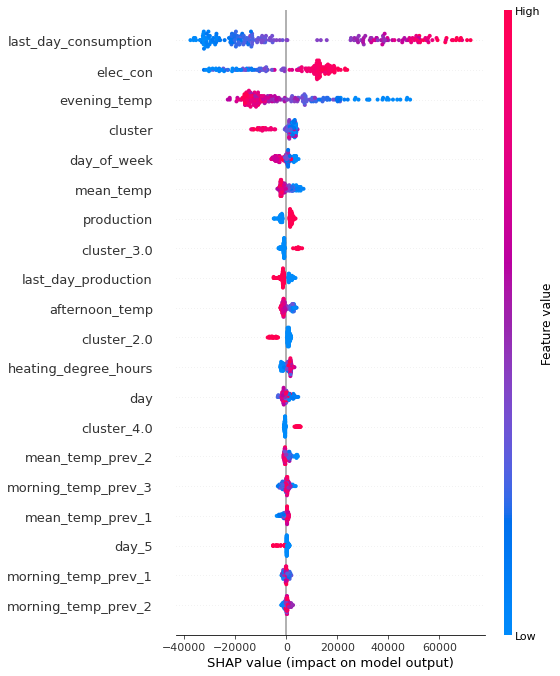

In [28]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

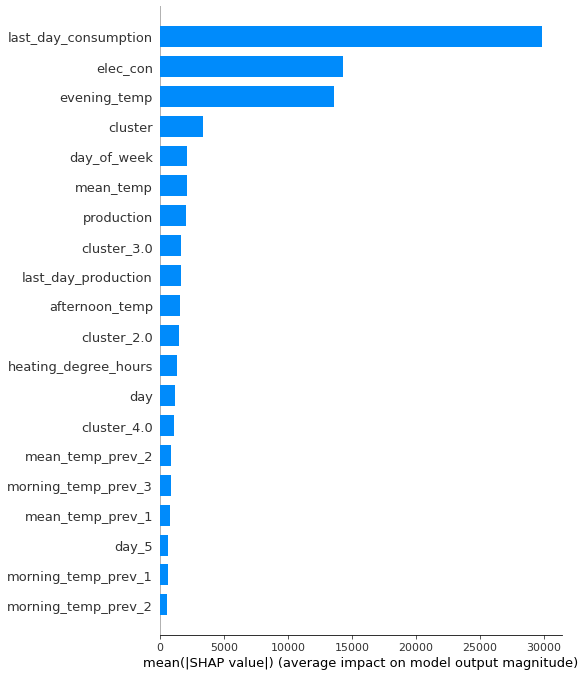

In [29]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

# CLUSTERS EXPLANATION

In [34]:
fs.insert(0, 'consumption')
#X = df[fs]

In [31]:
X

,mean_temp,heating_degree_hours,day,week,day_of_week,production,morning_temp,afternoon_temp,evening_temp,mean_temp_prev_1,...,day_5,day_6,cluster_0.0,cluster_1.0,cluster_2.0,cluster_3.0,cluster_4.0,cluster_5.0,cluster_6.0,cluster_7.0
date,,,,,,,,,,,,,,,,,,,,,
2020-01-04,0.994792,432.12500,4,1,5,0,1.750000,1.008333,0.212500,5.129167,...,1,0,0,1,0,0,0,0,0,0
2020-01-05,-0.445312,466.68750,5,1,6,0,-0.610417,-0.177083,-0.816667,0.994792,...,0,1,0,0,0,0,0,0,1,0
2020-01-06,0.147396,452.46250,6,2,0,0,0.581250,0.925000,-1.841667,-0.445312,...,0,0,0,1,0,0,0,0,0,0
2020-01-07,-0.491146,467.78750,7,2,1,0,-4.433333,0.672917,1.122917,0.147396,...,0,0,0,0,0,0,0,0,1,0
2020-01-08,-4.983854,575.61250,8,2,2,0,-1.852083,-5.011458,-8.060417,-0.491146,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02,9.503125,227.92500,306,44,2,1,8.564583,11.023958,7.400000,13.956250,...,0,0,0,0,0,0,1,0,0,0
2022-11-03,8.442188,253.38750,307,44,3,1,6.914583,8.710417,9.433333,9.503125,...,0,0,1,0,0,0,0,0,0,0
2022-11-04,13.538542,133.58750,308,44,4,1,8.010417,14.056250,18.031250,8.442188,...,0,0,0,0,1,0,0,0,0,0


<AxesSubplot:xlabel='mean_temp', ylabel='consumption'>

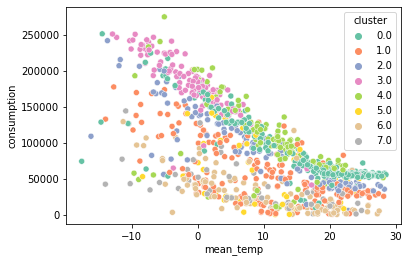

In [35]:
sns.scatterplot(data=df[fs[:-8]], x='mean_temp', y='consumption', hue='cluster', palette='Set2')

<AxesSubplot:xlabel='mean_temp', ylabel='consumption'>

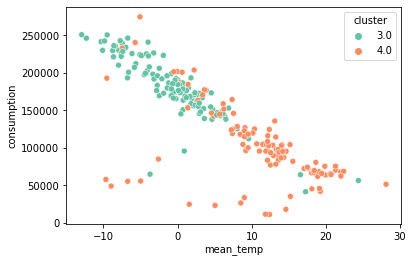

In [36]:
# clusters 3 & 4: high consumption, production days (differences: mean temperature & electricity) 
sns.scatterplot(data=df[df['cluster'].isin([3, 4])][fs[:-8]], x='mean_temp', y='consumption', hue='cluster', palette='Set2')

<AxesSubplot:xlabel='elec_con', ylabel='consumption'>

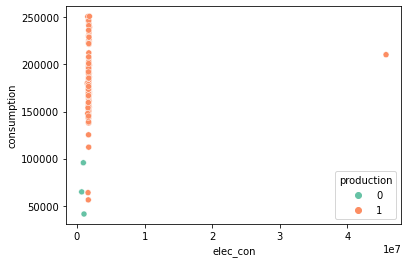

In [37]:
# cluster 3: high consumption, low temperature, production days, low electricity
# sns.scatterplot(data=df[df['cluster'].isin([3])][fs[:-8]], x='mean_temp', y='consumption', hue='production', palette='Set2')
sns.scatterplot(data=df[df['cluster'].isin([3])][fs[:-8]], x='elec_con', y='consumption', hue='production', palette='Set2')

<AxesSubplot:xlabel='elec_con', ylabel='consumption'>

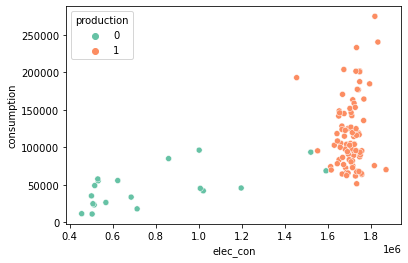

In [38]:
# cluster 4: high consumption, temperature: above zero, production days, high electricity
# sns.scatterplot(data=df[df['cluster'].isin([4])][fs[:-8]], x='mean_temp', y='consumption', hue='production', palette='Set2')
sns.scatterplot(data=df[df['cluster'].isin([4])][fs[:-8]], x='elec_con', y='consumption', hue='production', palette='Set2')

<AxesSubplot:xlabel='mean_temp', ylabel='consumption'>

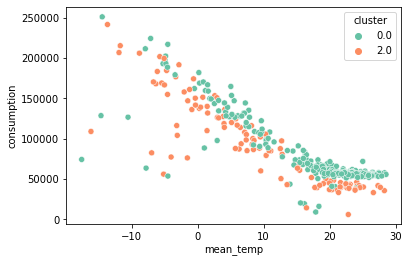

In [39]:
# clusters 0 & 2: high consumption, production days, low electricity (difference: Saturday)
sns.scatterplot(data=df[df['cluster'].isin([0, 2])][fs[:-8]], x='mean_temp', y='consumption', hue='cluster', palette='Set2')

<AxesSubplot:xlabel='mean_temp', ylabel='consumption'>

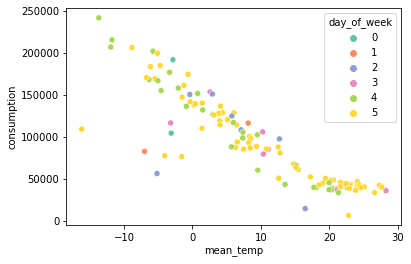

In [40]:
# cluster 2: high consumption, mostly in Saturday, productions day, low electricity
sns.scatterplot(data=df[df['cluster'].isin([2])][fs[:-8]], x='mean_temp', y='consumption', hue='day_of_week', palette='Set2')
#sns.scatterplot(data=df[df['cluster'].isin([2])][fs[:-8]], x='mean_temp', y='consumption', hue='production', palette='Set2')
# sns.scatterplot(data=df[df['cluster'].isin([3])][fs[:-8]], x='elec_con', y='consumption', hue='production', palette='Set2')

<AxesSubplot:xlabel='elec_con', ylabel='consumption'>

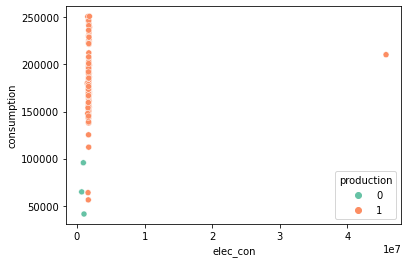

In [41]:
# cluster 0: high consumption, no Saturday (some misclassified), production days, low electricity
# sns.scatterplot(data=df[df['cluster'].isin([0])][fs[:-8]], x='mean_temp', y='consumption', hue='day_of_week', palette='Set2')
#sns.scatterplot(data=df[df['cluster'].isin([0])][fs[:-8]], x='mean_temp', y='consumption', hue='production', palette='Set2')
sns.scatterplot(data=df[df['cluster'].isin([3])][fs[:-8]], x='elec_con', y='consumption', hue='production', palette='Set2')

<AxesSubplot:xlabel='mean_temp', ylabel='consumption'>

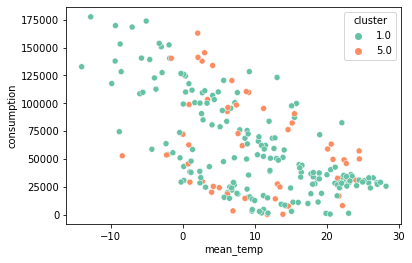

In [42]:
# clusters 1 & 5: medium consumption, non-production days (differences: electricity, Sunday)
sns.scatterplot(data=df[df['cluster'].isin([1, 5])][fs[:-8]], x='mean_temp', y='consumption', hue='cluster', palette='Set2')

<AxesSubplot:xlabel='mean_temp', ylabel='consumption'>

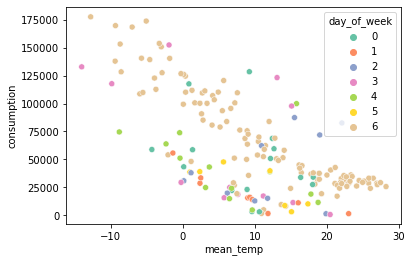

In [43]:
# cluster 1: medium consumption, low electricity, non-production days, Sunday
# sns.scatterplot(data=df[df['cluster'].isin([1])][fs[:-8]], x='elec_con', y='consumption', hue='production', palette='Set2')
sns.scatterplot(data=df[df['cluster'].isin([1])][fs[:-8]], x='mean_temp', y='consumption', hue='day_of_week', palette='Set2')

<AxesSubplot:xlabel='elec_con', ylabel='consumption'>

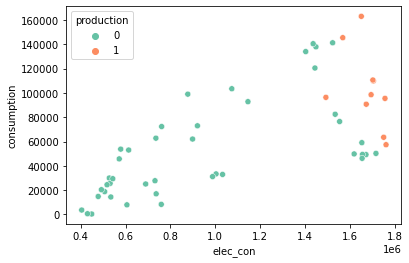

In [44]:
# cluster 5: medium consumption, high electricity, non-production days, not Sunday (some misclassified)
sns.scatterplot(data=df[df['cluster'].isin([5])][fs[:-8]], x='elec_con', y='consumption', hue='production', palette='Set2')
# sns.scatterplot(data=df[df['cluster'].isin([5])][fs[:-8]], x='mean_temp', y='consumption', hue='day_of_week', palette='Set2')

<AxesSubplot:xlabel='mean_temp', ylabel='consumption'>

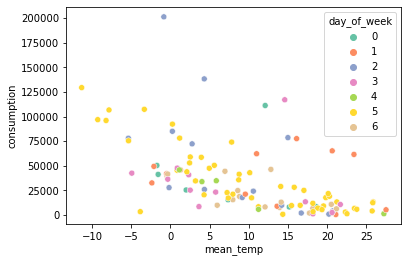

In [45]:
# cluster 6: low consumption, high electricity, production days, mostly Saturday
# sns.scatterplot(data=df[df['cluster'].isin([6])][fs[:-8]], x='elec_con', y='consumption', hue='production', palette='Set2')
# sns.scatterplot(data=df[df['cluster'].isin([6])][fs[:-8]], x='mean_temp', y='consumption', hue='production', palette='Set2')
sns.scatterplot(data=df[df['cluster'].isin([6])][fs[:-8]], x='mean_temp', y='consumption', hue='day_of_week', palette='Set2')

In [ ]:
# cluster 0: high consumption, no Saturday (some misclassified), production days, low electricity
# cluster 1: medium consumption, low electricity, non-production days, Sunday
# cluster 2: high consumption, mostly in Saturday, productions day, low electricity
# cluster 3: high consumption, low temperature, production days, low electricity
# cluster 4: high consumption, temperature: above zero, production days, high electricity
# cluster 5: medium consumption, high electricity, non-production days, not Sunday (some misclassified)
# cluster 6: low consumption, high electricity, production days, mostly Saturday

# CLUSTER FEATURES IMPORTANCE

In [85]:
fsx = ['mean_temp',
 'consumption',
 'week',
 'production',
 'elec_con',
 'day_0',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6']

In [75]:
X = df[fsx]
y = df['cluster_0.0']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
gbc = GradientBoostingClassifier(random_state=0)
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=12)
scores = cross_validate(gbc, X, y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                               'neg_mean_absolute_percentage_error'))
mt_cl_0 = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[-1*scores['test_neg_mean_absolute_error'].mean()], 
          'rmse':[-1*scores['test_neg_root_mean_squared_error'].mean()],
          'mape':[-1*scores['test_neg_mean_absolute_percentage_error'].mean()]}, index=['cluster0'])
mt_cl_0

,r2,mae,rmse,mape
cluster0,0.280584,19.371782,0.363748,2.586226e+14


## CLUSTER 0
# cluster 0: high consumption, no Saturday (some misclassified), production days, low electricity

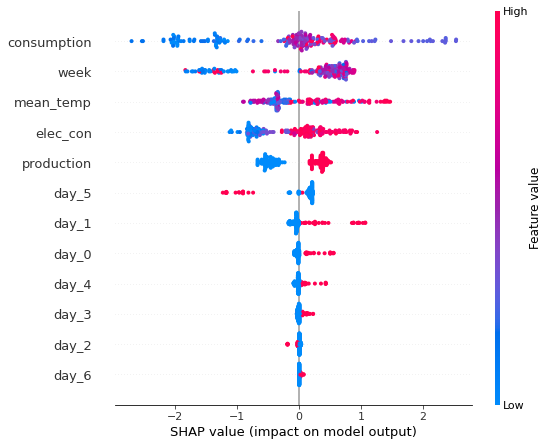

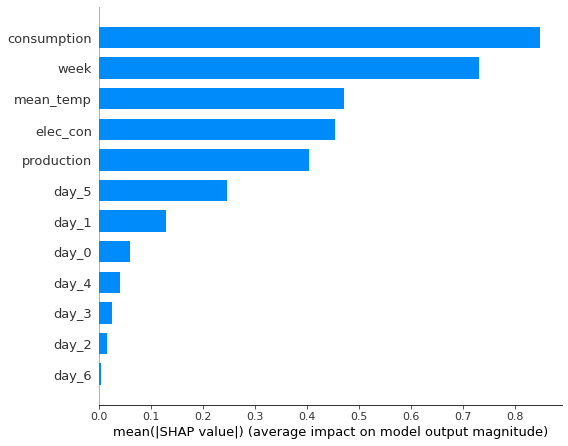

In [86]:
X = df[fsx]
y = df['cluster_0.0']
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

# Predict
prediction = gbc.predict(X_test)

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbc)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

## CLUSTER 1
# cluster 1: medium consumption, low electricity, non-production days, Sunday

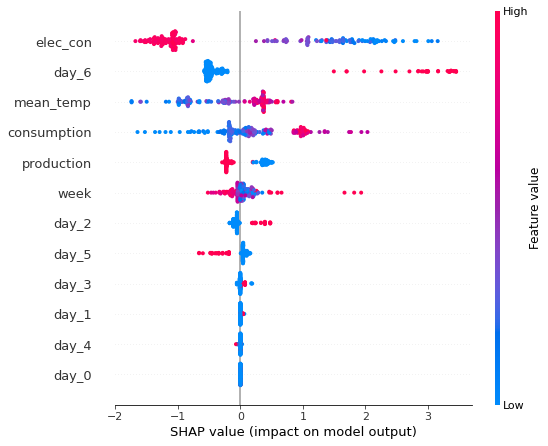

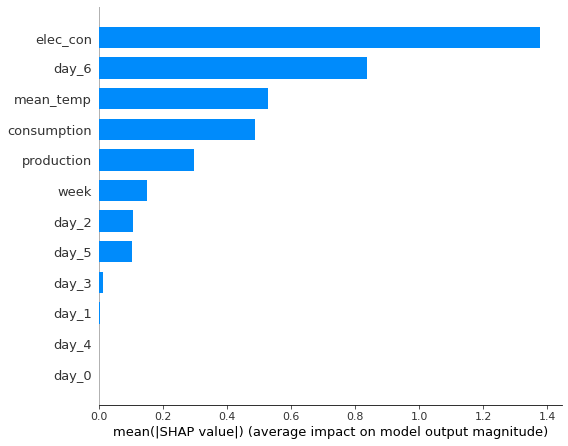

In [87]:
X = df[fsx]
y = df['cluster_1.0']
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

# Predict
prediction = gbc.predict(X_test)

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbc)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

## CLUSTER 2
# cluster 2: high consumption, mostly in Saturday, productions day, low electricity

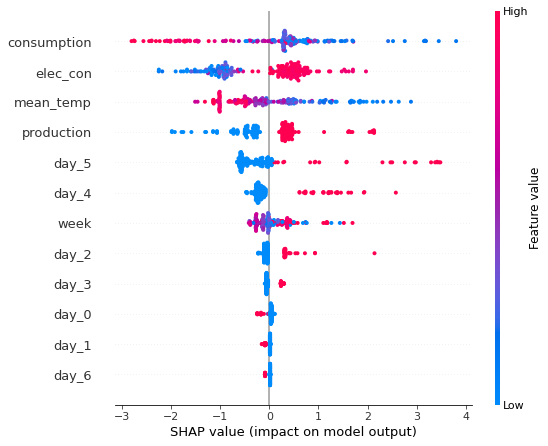

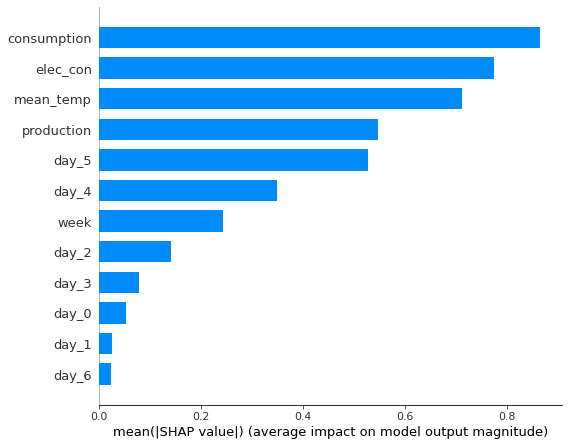

In [88]:
X = df[fsx]
y = df['cluster_2.0']
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

# Predict
prediction = gbc.predict(X_test)

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbc)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

## CLUSTER 3
# cluster 3: high consumption, low temperature, production days, low electricity

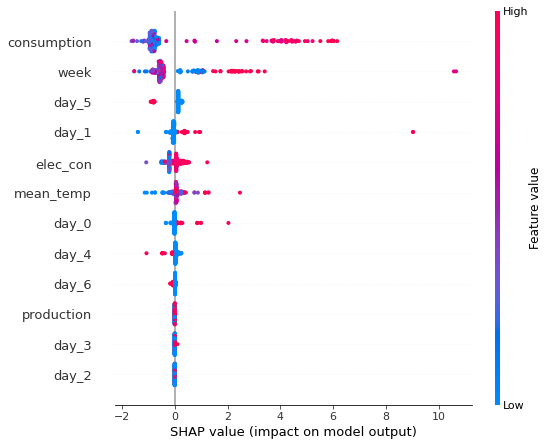

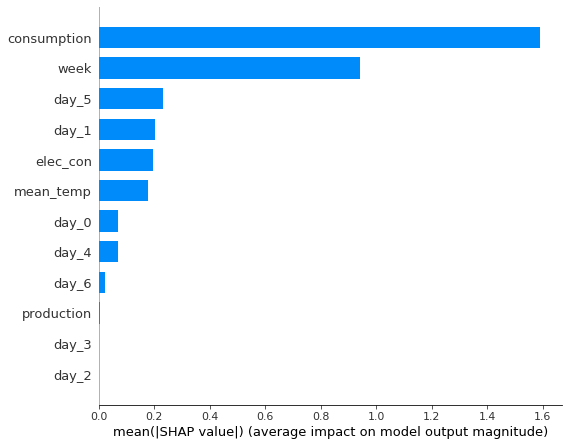

In [89]:
X = df[fsx]
y = df['cluster_3.0']
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

# Predict
prediction = gbc.predict(X_test)

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbc)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

## CLUSTER 4
# cluster 4: high consumption, temperature: above zero, production days, high electricity

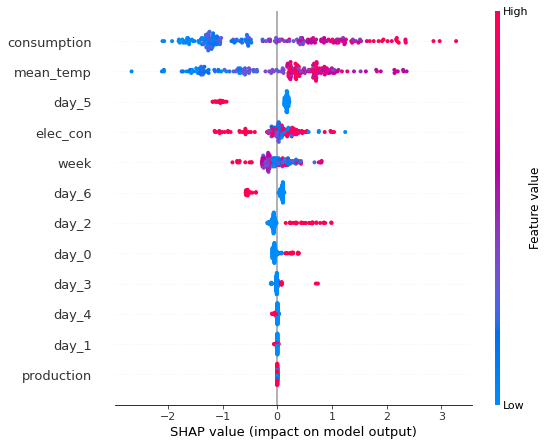

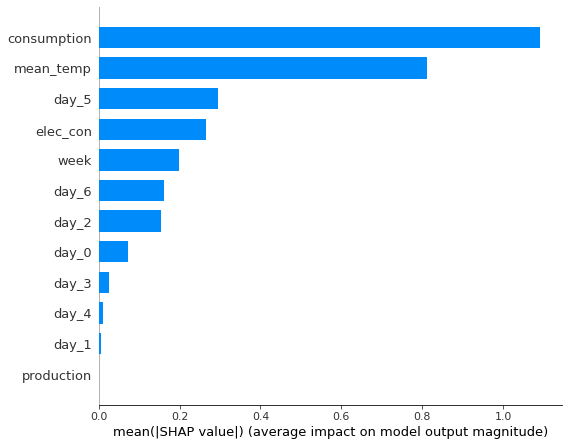

In [90]:
X = df[fsx]
y = df['cluster_4.0']
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

# Predict
prediction = gbc.predict(X_test)

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbc)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

## CLUSTER 5
# cluster 5: medium consumption, high electricity, non-production days, not Sunday (some misclassified)

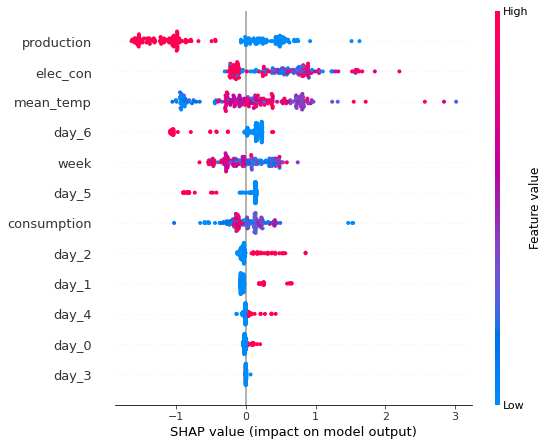

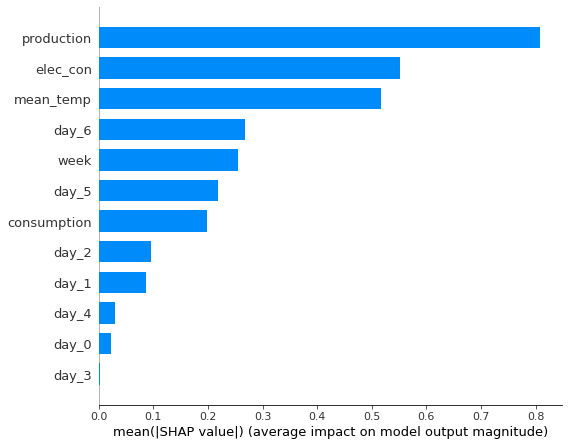

In [91]:
X = df[fsx]
y = df['cluster_5.0']
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

# Predict
prediction = gbc.predict(X_test)

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbc)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

## CLUSTER 6
# cluster 6: low consumption, high electricity, production days, mostly Saturday

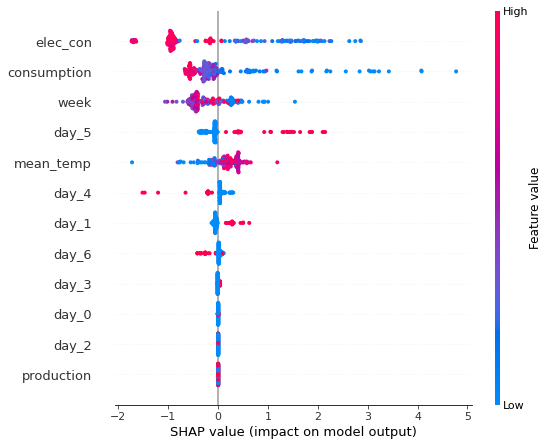

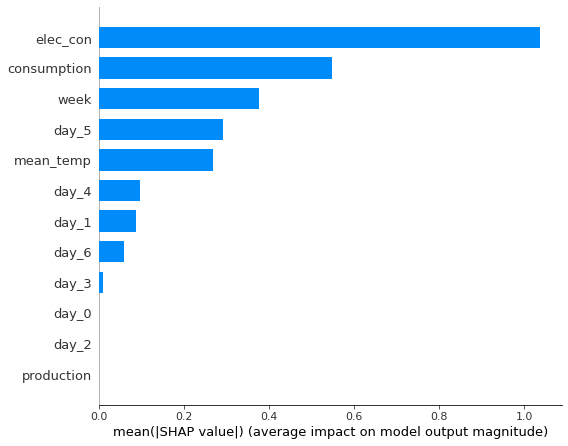

In [92]:
X = df[fsx]
y = df['cluster_6.0']
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

# Predict
prediction = gbc.predict(X_test)

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbc)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')